In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image

device = 'cpu' if torch.cuda.is_available() else 'cpu'


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

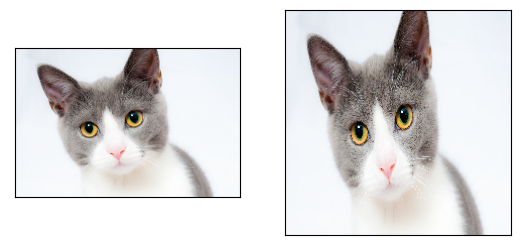

In [2]:
cat = read_image(str(Path('assets') / 'cat.jpg'))
cat_resize = read_image(str(Path('assets') / 'cat_resize.jpg'))
show([cat, cat_resize])

In [3]:
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        weights = VGG16_Weights.DEFAULT
        self.vgg16 = vgg16(weights=weights, progress=False).eval()
        self.transforms = weights.transforms()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            y_pred = self.vgg16(x)
            return y_pred

In [4]:
def show_prediction(pred):
    import json
    with open(Path('assets') / 'imagenet_class_index.json') as labels_file:
        labels = json.load(labels_file)
    print(f"Prediction: {labels[str(torch.argmax(pred).item())]}\nConfidence:{pred[0, torch.argmax(pred).item()]}")

In [5]:
predictor = Predictor().to(device)
batch = torch.stack([cat]).to(device)
res = predictor(batch)

show_prediction(res)

Prediction: ['n02124075', 'Egyptian_cat']
Confidence:14.164711952209473


In [6]:
class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        weights = VGG16_Weights.DEFAULT
        self.vgg16 = vgg16(weights=weights, progress=False).eval()
        self.transforms = weights.transforms()

    def forward(self, x: torch.Tensor, noise:torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            x_noise = x * noise
            y_pred = self.vgg16(x_noise)
            return y_pred

In [7]:
import cv2
import skimage.exposure
from numpy.random import default_rng


def generate_rmaps(n):
    r_maps = []
    r_maps.append(torch.ones([224,224]))
    for i in range(n-1):
        # define random seed to change the pattern
        rng = default_rng()
        # define image size
        width=224
        height=224
        # create random noise image
        noise = rng.integers(0, 255, (height,width), np.uint8, True)
        # blur the noise image to control the size
        blur = cv2.GaussianBlur(noise, (0,0), sigmaX=15, sigmaY=15, borderType = cv2.BORDER_DEFAULT)
        # stretch the blurred image to full dynamic range
        stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0,255)).astype(np.uint8)
        # threshold stretched image to control the size
        thresh = cv2.threshold(stretch, 175, 255, cv2.THRESH_BINARY)[1]
        # apply morphology open and close to smooth out shapes
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
        result = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)

        r_maps.append(torch.from_numpy((255-result)/255).long())
    return r_maps

#def generate_rmaps(n, p=0.49):
#    r_maps = []

#    r_maps.append(torch.ones([224,224]))
    
#    for i in range(n-1):
#        r_maps.append(torch.round(torch.rand([224,224])+p))
    
#    return r_maps

In [8]:
r_maps = generate_rmaps(1000)

outputs = []

for noise in r_maps:
    predictor = Predictor().to(device)
    batch = torch.stack([cat_resize]).to(device)
    res = predictor(batch, noise)
    outputs.append(res)

/tmp/ipykernel_1291/1353235803.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  show([torch.tensor(cat_resize*r_maps[5], dtype=torch.uint8)])


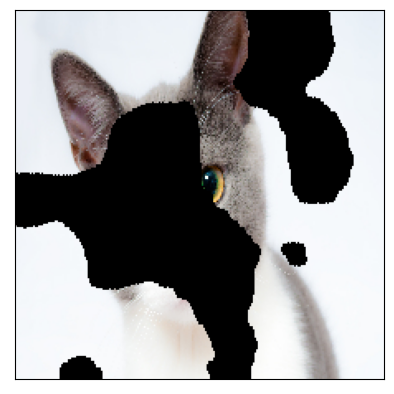

In [9]:
show([torch.tensor(cat_resize*r_maps[5], dtype=torch.uint8)])

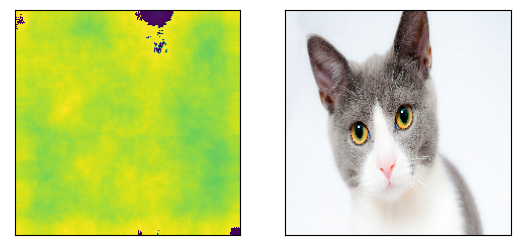

In [12]:
map = torch.zeros([224,224])

for i in range(len(r_maps)):
    map += r_maps[i]*(outputs[i][0, torch.argmax(outputs[0]).item()]-outputs[0][0, torch.argmax(outputs[0]).item()])/len(r_maps)

show([map, cat_resize])

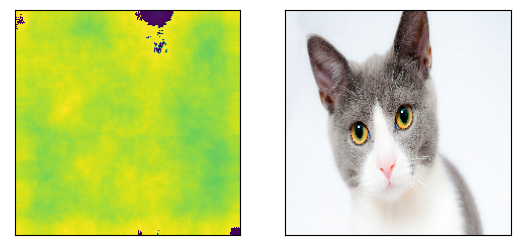

In [19]:
map = torch.zeros([224,224])

for i in range(len(r_maps)):
    map += r_maps[i]*(outputs[i][0, torch.argmax(outputs[0]).item()]-outputs[0][0, torch.argmax(outputs[0]).item()])/len(r_maps)

show([map, cat_resize])